### Question 1

### (a)

In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from tqdm.auto import tqdm, trange
import seaborn as sns

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
data_dir = os.path.join("/content/drive/My Drive", 'vgg-flowers')

In [8]:
torch.random.manual_seed(42)

In [9]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {
    split: datasets.ImageFolder(os.path.join(data_dir, split), data_transforms[split]) for split in ['train', 'val']
}
dataloaders = {
    split: DataLoader(image_datasets[split], batch_size = 64, shuffle = True) for split in ['train', 'val']
}
dataset_sizes = {
    split: len(image_datasets[split]) for split in ['train', 'val']
}
class_names = image_datasets['train'].classes

In [10]:
class_sizes = len(image_datasets['train'].classes)
print(f'Number of classes: {class_sizes}')

Number of classes: 102


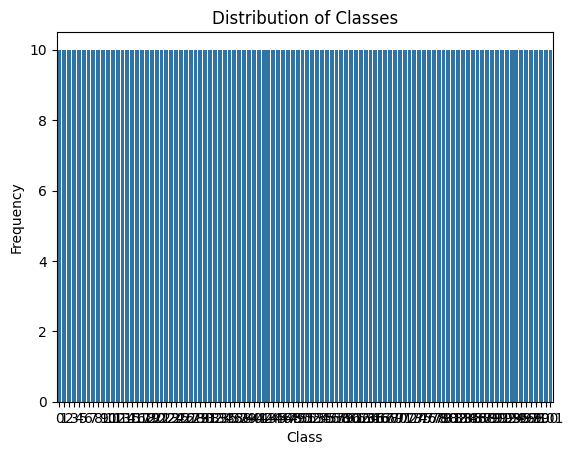

In [11]:
sns.countplot(x = image_datasets['train'].targets)
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

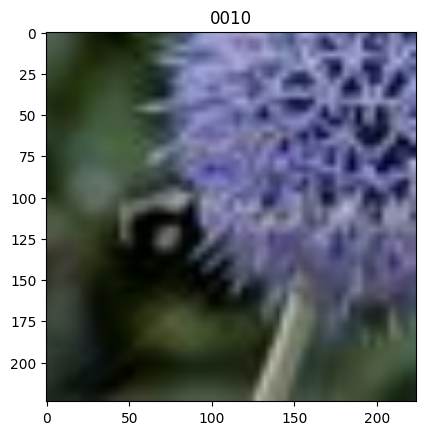

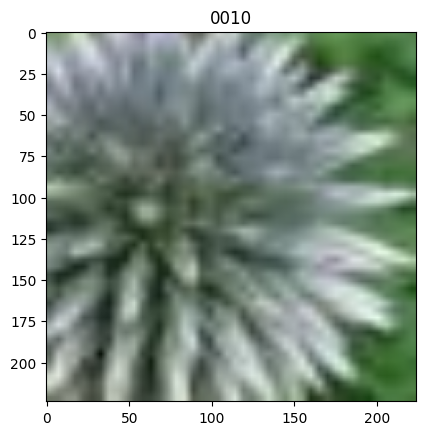

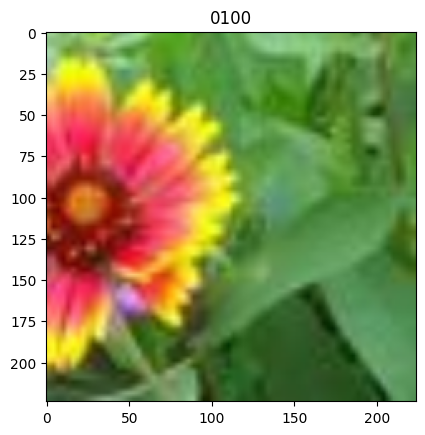

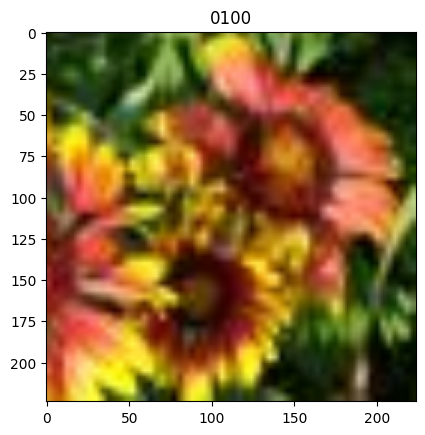

In [12]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


selected_num_1 = 0
selected_num_2 = 0
for data in dataloaders['train']:
    if selected_num_1 > 2 and selected_num_2 > 2:
        break
    for i in range(len(data[1])):
        label = class_names[data[1][i]]
        if label == '0010' and selected_num_1 < 2:
            imshow(data[0][i], label)
            selected_num_1 += 1
        elif  label == '0100' and selected_num_2 < 2:
            imshow(data[0][i], label)
            selected_num_2 += 1

### (b)

In [33]:
checkpoints = '/content/checkpoints'

In [34]:
def train_model(model, version, criterion, optimizer, scheduler = None, num_epochs=25):
    since = time.time()

    if os.path.exists(f'{checkpoints}/latest_checkpoint_{version}.pt'):
        checkpoint = torch.load(f'{checkpoints}/latest_checkpoint_{version}.pt')
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        if scheduler is not None:
            scheduler.load_state_dict(checkpoint['scheduler'])
        start_epoch = checkpoint['epoch']
    else:
        start_epoch = 0

    history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
    }

    best_acc = 0.0

    for epoch in trange(start_epoch, num_epochs):

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
            # for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train' and scheduler is not None:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.cpu())

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), f'{checkpoints}/best_{version}.pt')

        if scheduler is not None:
            torch.save({
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
            }, f'{checkpoints}/latest_checkpoint_{version}.pt')
        else:
            torch.save({
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, f'{checkpoints}/latest_checkpoint_{version}.pt')


    time_elapsed = time.time() - since
    print(f'training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'best val acc: {best_acc:4f}')

    model.load_state_dict(torch.load(f'{checkpoints}/best_{version}.pt'))

    return model, history, best_acc

In [35]:
def plot(history):
  fig, ax = plt.subplots(1, 2, figsize = (15, 5))
  ax[0].plot(history['train_loss'], color = 'c', label = 'Train')
  ax[0].plot(history['val_loss'], color = 'pink', label = 'Validation')
  ax[0].set_title('Training and Validation Loss over Epochs')
  ax[0].set_ylabel('Loss')
  ax[0].set_xlabel('Epoch')
  ax[0].legend()
  ax[0].grid(True)

  ax[1].plot(history['train_acc'], color = 'c', label = 'Train')
  ax[1].plot(history['val_acc'], color = 'pink', label = 'Validation')
  ax[1].set_title('Training and Validation Accuracy over Epochs')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylim(0, 1)
  ax[1].legend()
  ax[1].grid(True)
  plt.show()

In [36]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.MultiStepLR(optimizer_ft, milestones=[15, 30, 45], gamma=0.1)

In [37]:
model_ft, history_ft, best_acc = train_model(model_ft, 1, criterion, optimizer_ft, scheduler = exp_lr_scheduler,
                       num_epochs=60)

  0%|          | 0/60 [00:00<?, ?it/s]

training complete in 14m 8s
best val acc: 0.580392


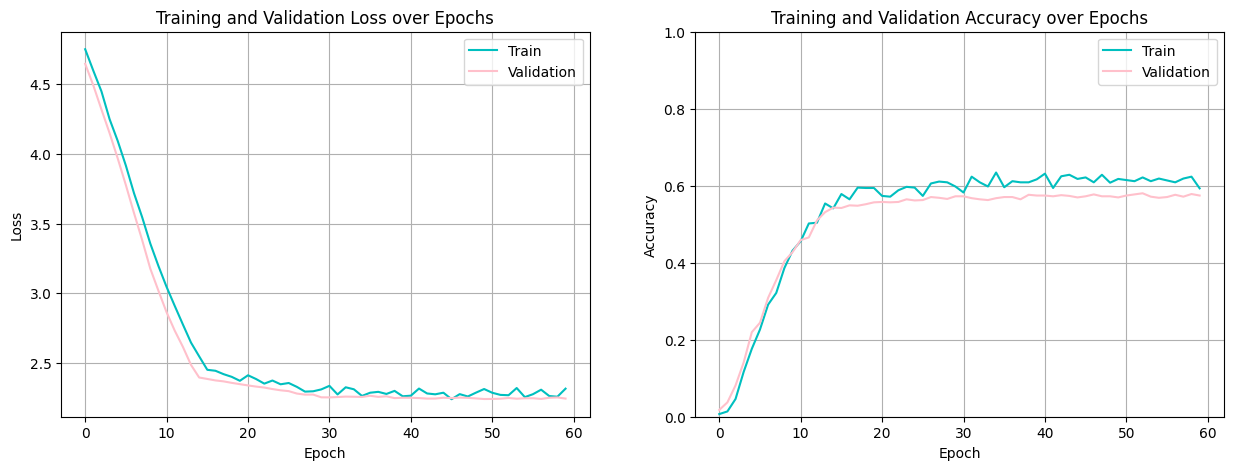

In [38]:
plot(history_ft)

### (c)

In [39]:
model_ft1 = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft1.fc.in_features
model_ft1.fc = nn.Linear(num_ftrs, len(class_names))

model_ft1 = model_ft1.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft1 = optim.SGD(model_ft1.parameters(), lr=0.01, momentum=0.9)

In [40]:
model_ft1, history_ft1, best_acc1 = train_model(model_ft1, 'fixed_1', criterion, optimizer_ft1,
                       num_epochs=60)

  0%|          | 0/60 [00:00<?, ?it/s]

training complete in 14m 5s
best val acc: 0.777451


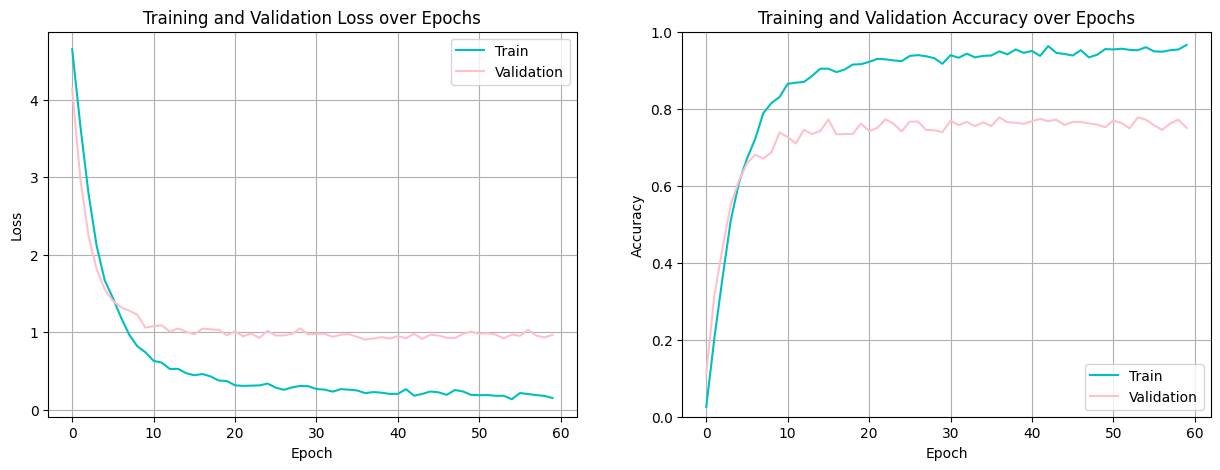

In [41]:
plot(history_ft1)

In [42]:
model_ft2 = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft2.fc.in_features
model_ft2.fc = nn.Linear(num_ftrs, len(class_names))

model_ft2 = model_ft2.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft2 = optim.SGD(model_ft2.parameters(), lr=0.1, momentum=0.9)

In [43]:
model_ft2, history_ft2, best_acc2 = train_model(model_ft2, 'fixed_2', criterion, optimizer_ft2,
                       num_epochs=60)

  0%|          | 0/60 [00:00<?, ?it/s]

training complete in 14m 4s
best val acc: 0.242157


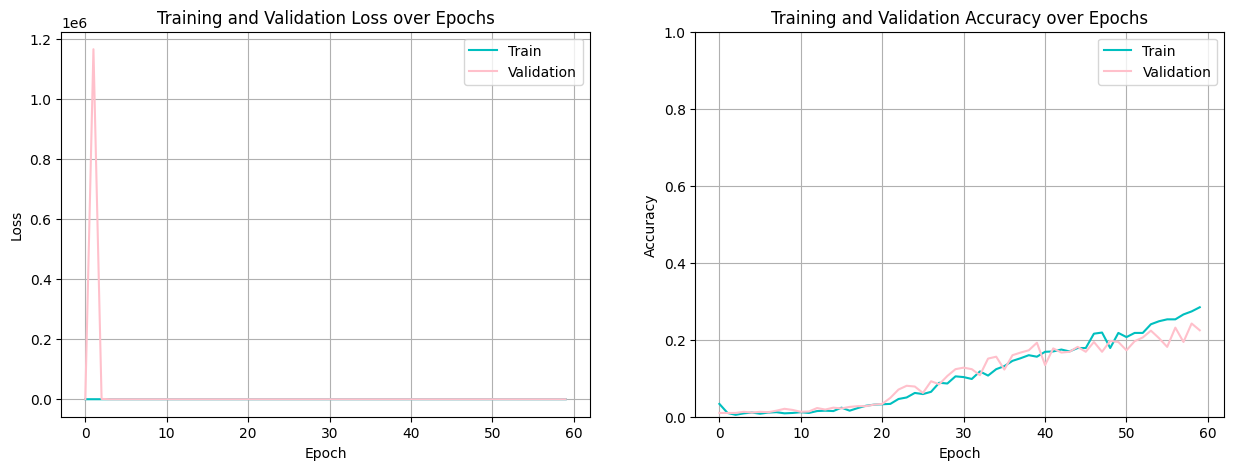

In [44]:
plot(history_ft2)

A learning rate of 0.001 gives an accuracy of about 58.04%. A learning rate of 0.01 gives an accuracy of 77.75%, and a learning rate of 0.1 gives an accuracy of about 24.22%. Therefore, the learning rate of 0.01 gave us the best accuracy on the target dataset, which was 77.75%.

### Question 2

### (a)

In [45]:
model_freeze = models.resnet18(weights='IMAGENET1K_V1')
for param in model_freeze.parameters():
    param.requires_grad = False
num_ftrs = model_freeze.fc.in_features
model_freeze.fc = nn.Linear(num_ftrs, len(class_names))

model_freeze = model_freeze.to(device)

criterion = nn.CrossEntropyLoss()

In [46]:
learning_rates = [0.001, 0.01, 0.1, 1]

for i, lr in enumerate(learning_rates):
  optimizer_freeze = optim.SGD(model_freeze.parameters(), lr=lr, momentum=0.9)

  print(f'learning rate: {lr}')
  model_freeze, history_freeze, best_acc_freeze = train_model(model_freeze, f'freeze_{i}', criterion, optimizer_freeze,
                       num_epochs=60)
  print()

learning rate: 0.001


  0%|          | 0/60 [00:00<?, ?it/s]

training complete in 12m 34s
best val acc: 0.573529

learning rate: 0.01


  0%|          | 0/60 [00:00<?, ?it/s]

training complete in 12m 27s
best val acc: 0.686275

learning rate: 0.1


  0%|          | 0/60 [00:00<?, ?it/s]

training complete in 12m 20s
best val acc: 0.613725

learning rate: 1


  0%|          | 0/60 [00:00<?, ?it/s]

training complete in 12m 23s
best val acc: 0.598039




A learning rate of 0.01 gives us the best accuracy on the target dataset, which is about 68.63% in this case.

### (b)

Between the two transfer learning approaches, which were (1) full-network fine-tuning and (2) freezing the layers and training only the last layer, a learning rate of 0.01 yielded the highest accuracy for both approaches (77.75% for the first approach, and 68.63% for the second approach). Therefore, the best approach would be full-network fine-tuning, with a learning rate of 0.01.

A plausible explanation for this is that full-network fine-tuning allows the model to adjust all of its weights, including the feature extraction layers, to be more suited to the target task. This provides the model with more flexibility to learn from the target dataset and adapt its internal representations. On the other hand, freezing the layers and only training the final layer means that the pretrained feature extraction layers remain fixed, which can limit the model's ability to fully adjust to the specifics of the new dataset. Essentially, when using frozen layers, the model may not be able to learn task-specific features effectively, leading to lower performance. This difference in approach explains why full network fine-tinuning performs better than training only the final layer.